# Plot shap results


In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import matplotlib.pyplot as plt
import pickle
from glob import glob
import numpy as np
import pandas as pd
import os

import shap

from sklearn.metrics import r2_score

plt.style.use(["science", "nature", "std-colors"])

colors = ["#0C5DA5", "#00B945", "#FF9500", "#FF2C00", "#845B97", "#474747", "#9e9e9e"]

LOG_CONVERSION = np.log(10)

from sonipredict.definitions import shap_global_feature_map_lab, shap_global_feature_map_merged


In [4]:
def read_pkl(f):
    with open(f, "rb") as handle:
        return pickle.load(handle)


This loads some model files created using the command `sonipredict.tune_pred`.

In [5]:
model_lab_z_av = read_pkl("2022-05-05-11-31__lab_log_z_av_99_model.pkl")

model_lab_pdi = read_pkl("2022-05-05-11-31__lab_PDI_95_model.pkl")

model_merged_z_av = read_pkl("2022-05-05-11-31__merged_log_z_av_14_model.pkl")

model_merged_pdi = read_pkl("2022-05-05-11-31__merged_PDI_99_model.pkl")


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [6]:
def transform_df(model, df):
    sub_pip = model.estimators[0].steps[:-1]
    X = sub_pip[0][1].transform(df[model.features])
    return X


In [7]:
df_merged = pd.read_pickle(
    os.path.join("..", "src", "sonipredict", "data", "preprocess_data_merged")
)
df_lab = pd.read_csv(
    os.path.join("..", "src", "sonipredict", "data", "AllSizes_allRuns.csv"), sep=";"
)


In [8]:
def get_indices(all_feature_names, feature_names_to_select):
    indices = []
    for name in feature_names_to_select:
        indices.append(np.where(all_feature_names == name)[0][0])
    return indices


In [9]:
def get_shap_contributions(shap, indices):
    return shap[indices].sum()


In [10]:
def get_collected_global_shap_values(model, df, map):
    model._train_all()
    shap, shap_mean = model.get_shap_values(df)
    global_feature_importance = np.abs(shap_mean).mean(axis=0)
    importances = {}

    fn = model.estimators[0].steps[0][1].get_feature_names_out()

    for d in map:
        importances[d["name"]] = get_shap_contributions(
            global_feature_importance, get_indices(fn, d["features"])
        )

    return importances


In [11]:
importances_lab_pdi = get_collected_global_shap_values(
    model_lab_pdi, df_lab, shap_global_feature_map_lab
)

importances_lab_z_av = get_collected_global_shap_values(
    model_lab_z_av, df_lab, shap_global_feature_map_lab
)


importances_merged_pdi = get_collected_global_shap_values(
    model_merged_pdi, df_merged, shap_global_feature_map_merged
)

importances_merged_z_av = get_collected_global_shap_values(
    model_merged_z_av, df_merged, shap_global_feature_map_merged
)


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


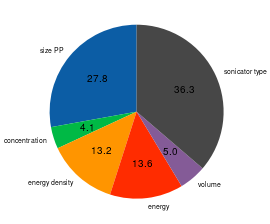

In [12]:
fig, ax = plt.subplots(1, 1)
ax.pie(
    importances_lab_pdi.values(),
    labels=importances_lab_pdi.keys(),
    colors=colors,
    startangle=90,
    autopct="%1.1f%%",
)
fig.savefig("pie_lab_pdi.pdf", bbox_inches="tight")


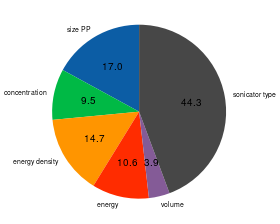

In [13]:
fig, ax = plt.subplots(1, 1)
ax.pie(
    importances_lab_z_av.values(),
    labels=importances_lab_z_av.keys(),
    colors=colors,
    startangle=90,
    autopct="%1.1f%%",
)
fig.savefig("pie_lab_z_av.pdf", bbox_inches="tight")


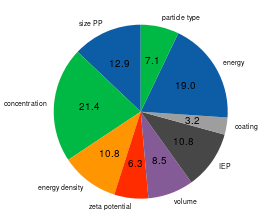

In [14]:
fig, ax = plt.subplots(1, 1)
ax.pie(
    importances_merged_pdi.values(),
    labels=importances_merged_pdi.keys(),
    colors=colors,
    startangle=90,
    autopct="%1.1f%%",
)
fig.savefig("pie_merged_pdi.pdf", bbox_inches="tight")


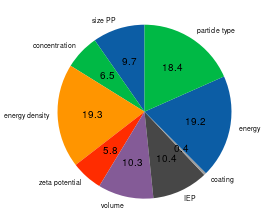

In [15]:
fig, ax = plt.subplots(1, 1)
ax.pie(
    importances_merged_z_av.values(),
    labels=importances_merged_z_av.keys(),
    colors=colors,
    startangle=90,
    autopct="%1.1f%%",
)
fig.savefig("pie_merged_z_av.pdf", bbox_inches="tight")


In [16]:
def get_summary_plot(model, df, shap_map, outname):
    names = []
    indices = []
    fn = model.estimators[0].steps[0][1].get_feature_names_out()

    for d in shap_map:
        if len(d["features"]) == 1:
            name = d["name"]
            indices_ = get_indices(fn, d["features"])
            names.append(name)
            indices.extend(indices_)

    model._train_all()
    shap_val, shap_mean = model.get_shap_values(df)
    X = transform_df(model, df)

    shap.summary_plot(
        shap_mean[:, indices],
        X[:, indices],
        plot_type="layered_violin",
        feature_names=names,
        show=False,
    )

    plt.savefig(outname, bbox_inches="tight")


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
not enough data in bin #0 for feature concentration, so it'll be ignored. Try increasing the number of records to plot.


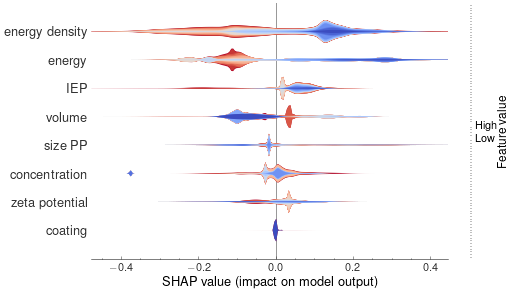

In [17]:
get_summary_plot(
    model_merged_z_av,
    df_merged,
    shap_global_feature_map_merged,
    "shap_summary_plot_merged_z_av.pdf",
)


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
not enough data in bin #0 for feature concentration, so it'll be ignored. Try increasing the number of records to plot.


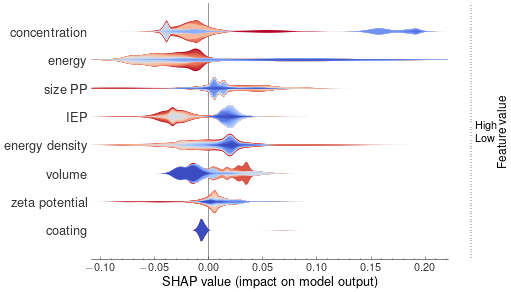

In [18]:
get_summary_plot(
    model_merged_pdi, df_merged, shap_global_feature_map_merged, "shap_summary_plot_merged_pdi.pdf"
)


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


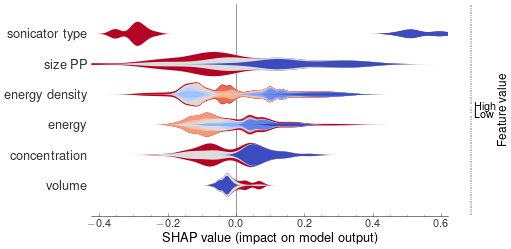

In [19]:
get_summary_plot(
    model_lab_z_av, df_lab, shap_global_feature_map_lab, "shap_summary_plot_lab_z_av.pdf"
)


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


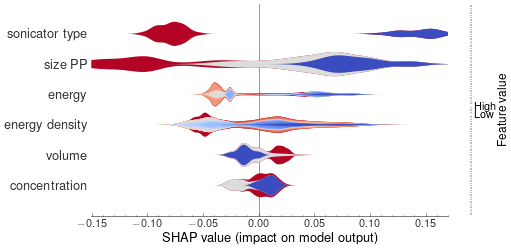

In [20]:
get_summary_plot(
    model_lab_pdi, df_lab, shap_global_feature_map_lab, "shap_summary_plot_lab_pdi.pdf"
)
